In [1]:
from torch.cuda.random import seed
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from torchvision.io import read_image
import random
from PIL import Image , ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms as Tran
from torchvision .models .detection. faster_rcnn import FastRCNNPredictor
torch.manual_seed(42)

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [2]:
#Reading the csv file
bd = pd.read_csv('/content/train_solution_bounding_boxes (1).csv')

In [3]:
#Getting unique images from the training images and csv file.
img_pth = '/content/training_images/'
img_unq = bd.image.unique()
print("The number of unique images is:",len(img_unq))

The number of unique images is: 355


In [4]:
#Creating DLCarData using the training_images
class DLCarData(torch.utils.data.Dataset):
    def __init__(self, bd, img_unq, indcs):
        self.bd = bd
        self.img_unq = img_unq
        self.indices = indcs

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        img_name = self.img_unq[self.indices[index]]
        bbx = self.bd[self.bd.image == img_name].values[: , 1:].astype("float")
        img = Image.open(img_pth + img_name).convert('RGB')
        labls = torch.ones((bbx.shape[0]) , dtype = torch.int64)
        targt = {}
        targt["boxes"] = torch.tensor(bbx)
        targt["label"] = labls

        return Tran.ToTensor()(img) , targt

In [5]:
#Splitting the DLCarData into Training dataset and Validation Dataset    
tr_indcs , vl_indcs = train_test_split(range(img_unq.shape[0]) , test_size = 0.4)

def collate(data):
    return data

tr_dlr = torch.utils.data.DataLoader(DLCarData(bd , img_unq, tr_indcs), 
                                       batch_size = 4,
                                       shuffle = True,
                                       collate_fn = collate,
                                       pin_memory = True if torch.cuda.is_available() else False)
                                       
vl_dlr = torch.utils.data.DataLoader(DLCarData(bd , img_unq, vl_indcs), 
                                       batch_size = 2,
                                       shuffle = True,
                                       collate_fn = collate,
                                       pin_memory = True if torch.cuda.is_available() else False)

In [6]:
#Downloading pretrainedmodel Resnet 50 for training the custom dataset
CarModel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
ncs = 2
n_fetures = CarModel.roi_heads.box_predictor.cls_score.in_features
CarModel.roi_heads.box_predictor = FastRCNNPredictor(n_fetures , ncs)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 98.9MB/s]


In [7]:
#Activating the GPU and using CUDA
dvce = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(dvce)

cuda:0


In [8]:
#Setting ther optimizer value
optmzr = torch.optim.SGD(CarModel.parameters() , lr=0.001, momentum=0.9, weight_decay=0.0005)

In [9]:
#Training the DLCarData Model
from tqdm import tqdm

ne = 50
CarModel.to(dvce)
for epochs in range(ne):
    epoch_loss = 0
    progress_bar = tqdm(tr_dlr, desc=f'Epoch {epochs + 1}/{ne}')
    for data in progress_bar:
        img = []
        targts = []
        for d in data:
            img.append(d[0].to(dvce))
            targt = {}
            targt["boxes"] = d[1]["boxes"].to(dvce)
            targt["labels"] = d[1]["label"].to(dvce)
            targts.append(targt)
        ls_dict = CarModel(img , targts)
        ls = sum(v for v in ls_dict.values())
        epoch_loss += ls.cpu().detach().numpy()
        optmzr.zero_grad()
        ls.backward()
        optmzr.step()
       
    print(f'Loss = {epoch_loss}')

Epoch 1/50: 100%|██████████| 54/54 [01:00<00:00,  1.12s/it]


Loss = 16.2037382724881


Epoch 2/50: 100%|██████████| 54/54 [00:56<00:00,  1.05s/it]


Loss = 7.77054043964625


Epoch 3/50: 100%|██████████| 54/54 [00:58<00:00,  1.09s/it]


Loss = 6.629450371731102


Epoch 4/50: 100%|██████████| 54/54 [00:59<00:00,  1.11s/it]


Loss = 6.178147048673671


Epoch 5/50: 100%|██████████| 54/54 [01:01<00:00,  1.13s/it]


Loss = 5.880741170059348


Epoch 6/50: 100%|██████████| 54/54 [01:01<00:00,  1.14s/it]


Loss = 5.371985577819001


Epoch 7/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 5.262277067032791


Epoch 8/50: 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


Loss = 4.895641946822373


Epoch 9/50: 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]


Loss = 4.620396185017048


Epoch 10/50: 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]


Loss = 4.605460299145844


Epoch 11/50: 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


Loss = 4.394562285783934


Epoch 12/50: 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


Loss = 4.206643674214783


Epoch 13/50: 100%|██████████| 54/54 [01:02<00:00,  1.17s/it]


Loss = 3.8773013883472816


Epoch 14/50: 100%|██████████| 54/54 [01:02<00:00,  1.17s/it]


Loss = 3.711447594817386


Epoch 15/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 3.648784331473654


Epoch 16/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 3.4835912357552195


Epoch 17/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 3.343172872732502


Epoch 18/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 3.1425614502418826


Epoch 19/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 2.9605208251562707


Epoch 20/50: 100%|██████████| 54/54 [01:02<00:00,  1.17s/it]


Loss = 2.902675492426877


Epoch 21/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 2.695268206837128


Epoch 22/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 2.6941427723760176


Epoch 23/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 2.548183336272938


Epoch 24/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 2.4337332324152734


Epoch 25/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 2.3129784182605118


Epoch 26/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 2.2076782781254094


Epoch 27/50: 100%|██████████| 54/54 [01:04<00:00,  1.19s/it]


Loss = 2.115479379951409


Epoch 28/50: 100%|██████████| 54/54 [01:03<00:00,  1.18s/it]


Loss = 2.0942086467630623


Epoch 29/50: 100%|██████████| 54/54 [01:02<00:00,  1.17s/it]


Loss = 1.9965042762881766


Epoch 30/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.9467772129017864


Epoch 31/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.8514274962529775


Epoch 32/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.762565180358484


Epoch 33/50: 100%|██████████| 54/54 [01:02<00:00,  1.17s/it]


Loss = 1.653747965403666


Epoch 34/50: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Loss = 1.717606395509312


Epoch 35/50: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Loss = 1.6234984290925443


Epoch 36/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.7176524488452896


Epoch 37/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.5980646513814172


Epoch 38/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.545100387626794


Epoch 39/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.4820335910395221


Epoch 40/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.3961989082782804


Epoch 41/50: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Loss = 1.3665105425870276


Epoch 42/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.3507356525705692


Epoch 43/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.3437946429363201


Epoch 44/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.2788439454014475


Epoch 45/50: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Loss = 1.315400632302404


Epoch 46/50: 100%|██████████| 54/54 [01:02<00:00,  1.16s/it]


Loss = 1.3689774869587141


Epoch 47/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.396024061653727


Epoch 48/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.3131346011930596


Epoch 49/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]


Loss = 1.2593548687895364


Epoch 50/50: 100%|██████████| 54/54 [01:03<00:00,  1.17s/it]

Loss = 1.2057584037208937


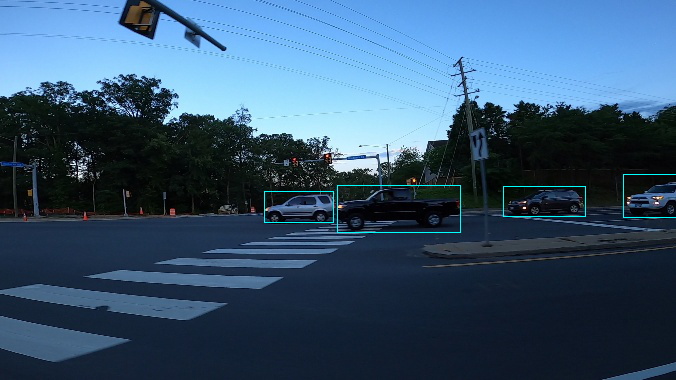

In [16]:
#Displaying the Validation images
CarModel.eval()

dt = iter(vl_dlr).__next__()
img = dt[0][0]
bbxs = dt[0][1]["boxes"]
lbls = dt[0][1]["label"]
rslt = CarModel([img.to(dvce)])
rslt_bbx = rslt[0]["boxes"]
rslt_scrs = rslt[0]["scores"]
kep = torchvision.ops.nms(rslt_bbx , rslt_scrs, 0.45)
rslt_bbx.shape , kep.shape
imn =(img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
rsmple = Image.fromarray(imn)
draw = ImageDraw.Draw(rsmple)
for box in bbxs:
    draw.rectangle(list(box) , fill = None , outline = 'cyan')
rsmple

In [38]:
#Calculating the accuracy of the validation set
CarModel.eval()

tcorrect = 0
tsamples = 0

with torch.no_grad():
    for data in vl_dlr:
        imgs = []
        targts = []
        for d in data:
            imgs.append(d[0].to(dvce))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(dvce)
            targ["labels"] = d[1]["label"].to(dvce)
            targts.append(targ)
        
        opt = CarModel(imgs)
        for i in range(len(opt)):
            pred_boxes = opt[i]['boxes']
            pred_labels = opt[i]['labels']
            
            # perform non-maximum suppression to get the final predicted boxes
            keep = torchvision.ops.nms(pred_boxes, pred_labels, iou_threshold=0.5)
            pred = pred_boxes[keep]
            pred = pred_labels[keep]

            
            # count the number of correct predictions
            for j in range(len(pred_boxes)):
                tboxes = targts[i]['boxes']
                tlabels = targts[i]['labels']
                tboxes = tboxes[tlabels == 1]
                iou = torchvision.ops.box_iou(pred_boxes[j].unsqueeze(0), tboxes)
                if iou.max() > 0.804:
                  tcorrect += 1
        
        tsamples += len(data)
        

valid_acc = tcorrect / tsamples
print("The Validation accuracy is = {:.2f}%".format(valid_acc * 100))


The Validation accuracy is = 97.18%


In [39]:
#Saving the trained model in the Working Directory
torch.save(CarModel.state_dict(), 'CarModel.pt')

In [40]:
#Execute this cell if GPU RAM runs out of memory
import torch
torch.cuda.empty_cache()

In [41]:
import os
import random
import torch
import torchvision
from PIL import Image, ImageDraw
from tqdm import tqdm
from torchvision import transforms as Tr


# Loading the trained model
cmodel = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=2)
cmodel.load_state_dict(torch.load('CarModel.pt'))
cmodel.eval()

# Defining the path to the images
testingpath = '/content/testing_images'
names = os.listdir(testingpath)


all_boxes = []


iou_threshold = 0.2
print("Predicting Boxes of the Test Data")

for name in tqdm(names):
    
    image = Image.open(os.path.join(testingpath, name)).convert('RGB')
    
    #Predict the car in the images
    with torch.no_grad():
        pred = cmodel([Tr.ToTensor()(image)])
    
    #Predict boxes and labels
    boxes = pred[0]['boxes'].detach().numpy()
    scores = pred[0]['scores'].detach().numpy()
    labels = pred[0]['labels'].detach().numpy()
    
    
    kp_indices = torchvision.ops.nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)
    bboxs = boxes[kp_indices]
    labls = labels[kp_indices]
    
    # Add boxes and label to list
    all_boxes.append({'image_name': name, 'boxes': bboxs, 'labels': labls})


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 239MB/s]


Predicting Boxes of the Test Data


100%|██████████| 175/175 [21:19<00:00,  7.31s/it]


In [42]:
#Importing the font for displaying distance
import os
import urllib.request
font_url = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true'
font_path = '/content/fonts/Roboto-Regular.ttf'
os.makedirs(os.path.dirname(font_path), exist_ok=True)
urllib.request.urlretrieve(font_url, font_path)

('/content/fonts/Roboto-Regular.ttf',
 <http.client.HTTPMessage at 0x7efeb2563760>)

Displaying The Images with Distance:
vid_5_25120.jpg


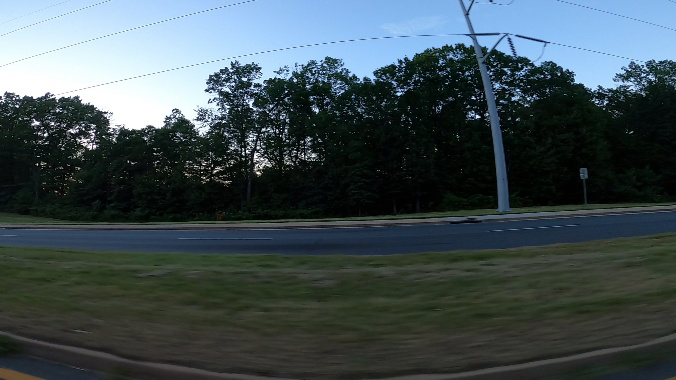

vid_5_31040.jpg


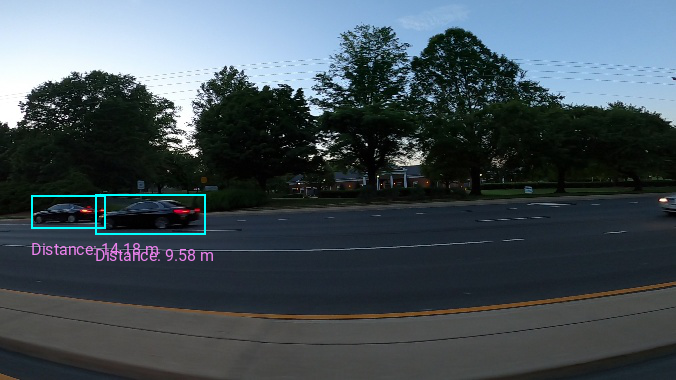

vid_5_27480.jpg


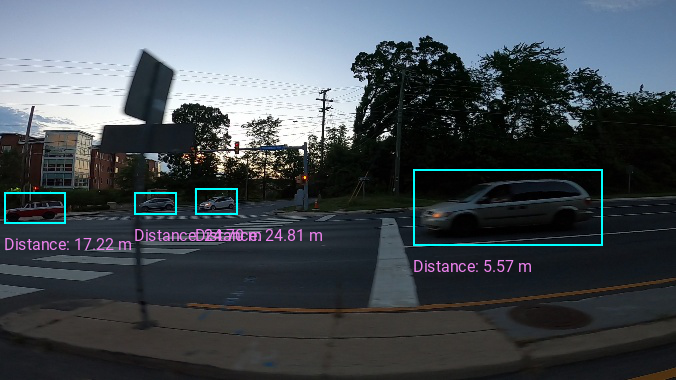

vid_5_26900.jpg


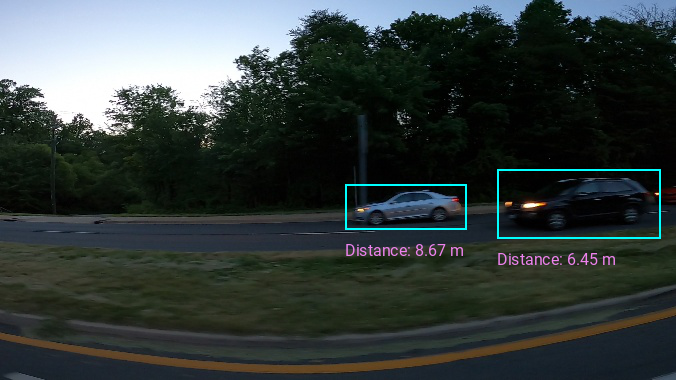

vid_5_29420.jpg


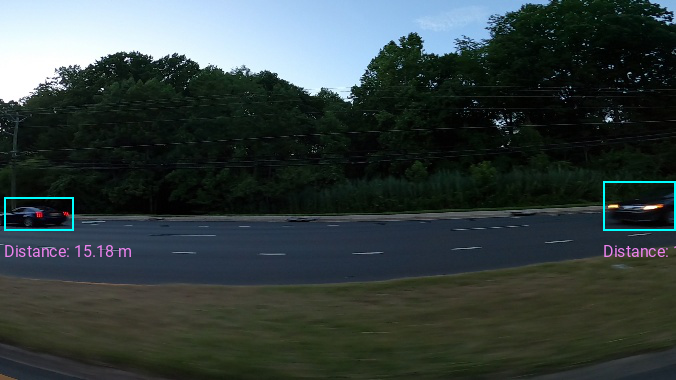

In [43]:
from PIL import ImageFont

print("Displaying The Images with Distance:")
dimg=['vid_5_25120.jpg', 'vid_5_31040.jpg','vid_5_27480.jpg','vid_5_26900.jpg','vid_5_29420.jpg']
for i in range(5):
    #Random image from list
    imge_name = dimg[i]
    imge_info = [info for info in all_boxes if info['image_name'] == imge_name][0]

    imge = Image.open(os.path.join(testingpath, imge_info['image_name'])).convert('RGB')

    # Predicted boxes drawing
    dr = ImageDraw.Draw(imge)
    for l in range(len(imge_info['boxes'])):
        bx = imge_info['boxes'][l]
        labls = imge_info.get('labels', [])
        if isinstance(labls, int):
            labls = [labls]
        if len(labls) > l:
            labl = labls[l]
        else:
            label = ''
        dr.rectangle([(bx[0], bx[1]), (bx[2], bx[3])], outline='cyan', width=2)
        
        # Distance of car using camera
        crwidth = 210  #width of car in cm
        folength = 5   #camera's focal length in cm
        crpixelwidth = bx[2] - bx[0]
        dist = (crwidth * folength) / crpixelwidth

        # Font existence check
        if os.path.isfile('/content/fonts/Roboto-Regular.ttf'):
            fnt = ImageFont.truetype('/content/fonts/Roboto-Regular.ttf', 16)
            dr.text((bx[0], bx[3] + 10), f"Distance: {dist:.2f} m", fill='violet', font=fnt)
        else:
            dr.text((bx[0], bx[3] + 10), f"Distance: {dist:.2f} m", fill='violet')

    # Display the image
    print(imge_info['image_name'])
    imge.show()
